# Bank Customers Segmentation using K-means Clustering 
*This is a personal portfolio project by Thamilini P.* <br>
<br>
October 24, 2023

## Table of Contents 
* [Ask Phase](#section-one)
    - [Task/Objectives](#objectives)
* [Prepare Phase](#section-two)
    - [Import dataset as Dataframe](#dataframe)
    - [Datatypes and Descriptive Statistics](#datatype-stats)
* [Process Phase](#section-three)
    - [Missing Values](#missing-values)
    - [Duplicate Values](#duplicate-values)
    - [Outliers](#outliers)
    - [Create and Transform Columns](#transform)  
* [Analyze Phase](#section-three)
    - [Standardize Dataset](#standardize)
    - [Determine Optimal K Clusters (Elbow Plot)](#elbow-plot)
    - [Perform K-Means Clustering](#k-means)
    - [Cluster Analysis](#cluster-analysis)
    - [Cluster Insights](#cluster-insights)
    - [Identify High-Value Customers Cluster](#high-value)
    - [Personalized Marketing Recommendations](#recommendations)

<a id="section-one"></a>
## Ask Phase

### Datasets Source

This case study analysis uses the "Clustering-Bank Dataset" from [Kaggle](https://www.kaggle.com/datasets/gopi1035/clusteringbank-dataset?). This dataset contains customer and branch details for a leading retail bank in India. The bank aims to use customer segmentation to improve their customer services (i.e.the wait times and frequency of marketing emails). 

<a id="objectives"></a>
### Task/Objectives

- Segment bank customers into clusters based on their demographics and relationship with the bank. 
- Identify high-value customers within the segmentation to provide them with priority service. 
- Leverage insights from clusters to better understand customers and develop personalized marketing.   

<a id="section-two"></a>
## Prepare Phase

#### Load R Packages

In [20]:
library(tidyverse)
library(skimr)
library(janitor)
library(lubridate)
library(ggplot2)
library(gridExtra)

<a id="dataframe"></a>
#### Import datasets as dataframe

In [21]:
customerDetails <- read.csv("/kaggle/input/clusteringbank-dataset/CustomerDetails.csv")
branchDetails <- read.csv("/kaggle/input/clusteringbank-dataset/BranchDetails.csv")

<a id="datatype-stats"></a>
Before performing clustering we will try to understand our datasets first. We will perform the following:
- Check datatypes
- Descriptive/Summary Statistics
- Missing Values
- Duplicate Values
- Check for outliers

In [22]:
skim_without_charts(branchDetails)
head(branchDetails)

,skim_type,skim_variable,n_missing,complete_rate,character.min,character.max,character.empty,character.n_unique,character.whitespace
,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,character,City,0,1,0,18,25,3071,0
2,character,BranchType,0,1,0,9,25,4,0


── Data Summary ────────────────────────
                           Values       
Name                       branchDetails
Number of rows             3095         
Number of columns          2            
_______________________                 
Column type frequency:                  
  character                2            
________________________                
Group variables            None         

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 City                  0             1   0  18    25     3071          0
2 BranchType            0             1   0   9    25        4          0


,City,BranchType
,<chr>,<chr>
1,MUMBAI,Urban
2,BANGALORE,Urban
3,GURGAON,Urban
4,NOIDA,Urban
5,PUNE,Urban
6,CHENNAI,Urban


- **City**: City of branch
- **BranchType**: Classification of branch based on the city its in (Urban,Semi-Urban,Rural)

Let's take a deeper look into the customerDetails statistics.

In [23]:
skim_without_charts(customerDetails)
head(customerDetails)

,skim_type,skim_variable,n_missing,complete_rate,character.min,character.max,character.empty,character.n_unique,character.whitespace,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100
,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,character,CustomerID,0,1,8,8,0,813486,0,NA,NA,NA,NA,NA,NA,NA
2,character,DateOfBirth,0,1,10,10,0,17083,0,NA,NA,NA,NA,NA,NA,NA
3,character,Gender,0,1,1,1,0,2,0,NA,NA,NA,NA,NA,NA,NA
4,character,City,0,1,0,18,23,3087,0,NA,NA,NA,NA,NA,NA,NA
5,numeric,AccountBalance,0,1,NA,NA,NA,NA,NA,1.069175e+05,8.310880e+05,0,4624,16214,54498,164489264
6,numeric,HavingFD,0,1,NA,NA,NA,NA,NA,3.635657e-01,4.810259e-01,0,0,0,1,1
7,numeric,HavingCC,0,1,NA,NA,NA,NA,NA,3.044975e-01,4.601945e-01,0,0,0,1,1
8,numeric,CIBIL_Score,0,1,NA,NA,NA,NA,NA,5.997184e+02,1.733190e+02,300,450,600,750,899
9,numeric,HavingLoan,0,1,NA,NA,NA,NA,NA,4.488509e-01,4.973771e-01,0,0,0,1,1


── Data Summary ────────────────────────
                           Values         
Name                       customerDetails
Number of rows             949039         
Number of columns          10             
_______________________                   
Column type frequency:                    
  character                4              
  numeric                  6              
________________________                  
Group variables            None           

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 CustomerID            0             1   8   8     0   813486          0
2 DateOfBirth           0             1  10  10     0    17083          0
3 Gender                0             1   1   1     0        2          0
4 City                  0             1   0  18    23     3087          0

── Variable type: numeric ──────────────────────────────────────────────────

,CustomerID,DateOfBirth,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,C6532335,1990-04-01,M,ABHANPUR,25025,0,0,775,0,51384
2,C6232347,1990-04-01,M,ABHANPUR,25025,1,0,765,0,94271
3,C4284828,1994-05-13,F,ABOHAR,1985,0,0,373,0,83163
4,C8784892,1994-05-13,F,ABOHAR,1985,0,0,676,0,1985
5,C5416341,1991-12-04,F,ABOHAR,3,0,0,513,0,149484
6,C5416341,1977-06-17,M,DELHI,102124,0,0,331,1,149484


Below are the definitions for the CustomerDetails column variables:

- **CustomerID**: Customer Identification.

- **DateOfBirth**: Date of birth of the customer.

- **Gender**: Gender of the customer.

- **City**: City where the customer resides.

- **AccountBalance**: Current account balance available in the account.

- **HavingFD**: If the customer has FD (Fixed Deposit). A FD is a amount deposited in the bank for a fixed tenure and interest rate. After the end of the tenure, the customer receives the orginal amount plus interest earned [Definition](https://www.hdfcbank.com/personal/resources/learning-centre/save/what-is-a-fixed-deposit#:~:text=So%2C%20what%20exactly%20is%20a,are%20also%20called%20term%20deposits).
    - 0 - means no FD
    - 1 - means yes has FD

- **HavingCC**: If the customer has Credit Card.
    - 0 - means no Credit Card
    - 1 - means yes has Credit Card

- **CIBIL_Score**: Lies between 300-900 and signifies the customer's creditworthiness. A score above 700 is generally considered good.

- **HavingLoan** - If the customer has Loan
    - 0- No Loan
    - 1- Yes Has Loan.

- **RV** - Total quantitative relationship values with the bank. It is the sum of all balances of accounts held with the bank (i.e.AccountBalance, FD, Credit Card, Loan). [Definition](https://www.dbs.com/digibank/in/articles/save/high-yield-savings-accounts#)

<a id="section-three"></a>
## Process Phase

<a id="missing-values"></a>
#### Missing Values

The above results tell us that there are 23 rows where the city column is empty. Since we want to include customer's city/region in clustering, we will filter out the rows with no city.

In [24]:
customerDetails <- filter(customerDetails,City!="")

#### Joining Datatables

Using the city column in from both tables lets add the branchType column to the customerDetails table. This will tell us about the closest branch to the customer.

In [25]:
customerDetails <- merge(x=customerDetails,y=branchDetails,by="City",all.x = TRUE)

head(customerDetails)

,City,CustomerID,DateOfBirth,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,BranchType
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>
1,ABHANPUR,C6232347,1990-04-01,M,25025,1,0,765,0,94271,Rural
2,ABHANPUR,C6532335,1990-04-01,M,25025,0,0,775,0,51384,Rural
3,ABOHAR,C4284828,1994-05-13,F,1985,0,0,373,0,83163,Rural
4,ABOHAR,C7320169,1972-01-01,M,15560,1,0,879,0,139635,Rural
5,ABOHAR,C7325325,1992-05-15,F,2184,0,0,828,0,82357,Rural
6,ABOHAR,C5416341,1991-12-04,F,3,0,0,513,0,149484,Rural


Now our customer details table tells us the type of branch is closest to our customer. i.e. Rural, Semi-Urban, Urban

<a id="duplicate-values"></a>
#### Duplicate Values

In [26]:
get_dupes(customerDetails)

No variable names specified - using all columns.


No duplicate combinations found of: City, CustomerID, DateOfBirth, Gender, AccountBalance, HavingFD, HavingCC, CIBIL_Score, HavingLoan, ... and 2 other variables



City,CustomerID,DateOfBirth,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,BranchType,dupe_count
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<int>


<a id="transform"></a>
#### Create Age Column

Let's use the lubridate package to convert DateofBirth into a date datatype and calculate the customer's age.

In [27]:
#convert DateofBirth as a date datatype
customerDetails$DateOfBirth <- ymd(customerDetails$DateOfBirth)

customerDetails <- customerDetails %>%
  mutate(age = year(Sys.Date())-year(customerDetails$DateOfBirth))

This tells us that in this dataset the youngest customer is 2 years old and the oldest is 93 years old. If we create age groups of size 10, then the mean and median would fall in the same age group (30, 40].

Let's plot a histogram to visualise the distribution of age groups.

Warning message in geom_histogram(aes(fill = prop), stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


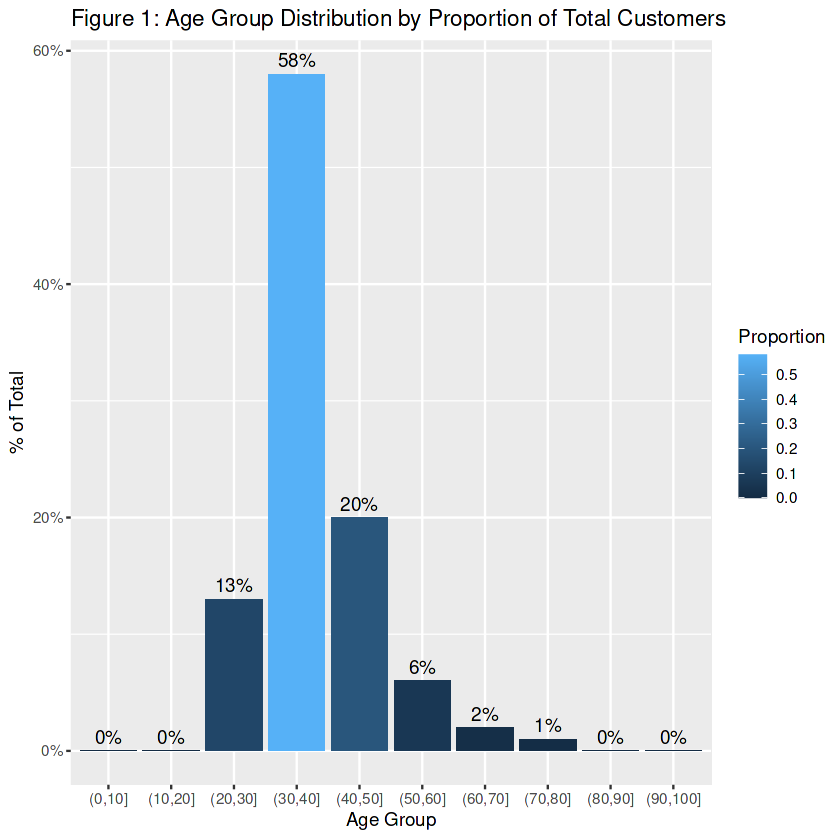

In [57]:
total <- nrow(customerDetails)

customerDetails %>% 
  mutate(age_grp = cut(customerDetails$age, seq(0,100,by=10))) %>% 
  group_by(age_grp) %>% 
  summarise(prop= round((n()/total),2)) %>% 
  ggplot(aes(x=age_grp,y=prop))+geom_histogram(aes(fill = prop),stat="identity") +geom_text(aes(label = scales::percent(prop), y = prop), stat = "identity", vjust = -0.5) + scale_y_continuous(labels=scales::percent)+ labs(y = "% of Total", x="Age Group", fill="Proportion") +
  ggtitle("Figure 1: Age Group Distribution by Proportion of Total Customers")


58% of customers in the dataset are found from just one Age Group (30,40]. This implies that more than half of the bank customers are in their 30s.

#### Encoding as numeric values

Since we know the branchtype of all customers this can provide additional insights. However in order to use it with k-means clustering we need to encode it as numeric values.

In [29]:
unique(customerDetails$BranchType)

[1] "Rural"     "Semi-Urba" "Urban"     NA

Since there are only 3 distinct values, lets represent them with integers. (i.e. Rural=0,Semi-Urba=1,Urban=2)

In [30]:
customerDetails <- customerDetails %>% 
  mutate(branchCode= case_when(
    BranchType == "Rural" ~ 0,
    BranchType == "Semi-Urba" ~ 1,
    BranchType == "Urban" ~ 2
  ))

Since we added two columns let remove any rows that have NA

In [31]:
customerDetails <- na.omit(customerDetails)

<a id="outliers"></a>
#### Outliers

Let's take a look at the summary statistics of the quantitative values.

In [32]:
customerDetails %>% 
  summary()

     City            CustomerID         DateOfBirth            Gender         
 Length:948995      Length:948995      Min.   :1930-01-01   Length:948995     
 Class :character   Class :character   1st Qu.:1982-01-16   Class :character  
 Mode  :character   Mode  :character   Median :1987-08-27   Mode  :character  
                                       Mean   :1985-06-05                     
                                       3rd Qu.:1991-04-30                     
                                       Max.   :2021-01-19                     
 AccountBalance         HavingFD         HavingCC       CIBIL_Score   
 Min.   :        0   Min.   :0.0000   Min.   :0.0000   Min.   :300.0  
 1st Qu.:     4624   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:450.0  
 Median :    16214   Median :0.0000   Median :0.0000   Median :600.0  
 Mean   :   106897   Mean   :0.3636   Mean   :0.3045   Mean   :599.7  
 3rd Qu.:    54488   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:750.0  
 Max.   :164489264   

Note that some variables like AccountBalance and RV have a significantly higher range compared to the other variables. The max values are significantly higher than the 3rd quartile suggesting that there are outliers. Let's check for outliers

The difference in ranges between variables could pose a problem when clustering since clusters are formed by a distance metric. Therefore we would need to standardize our dataset before clustering.

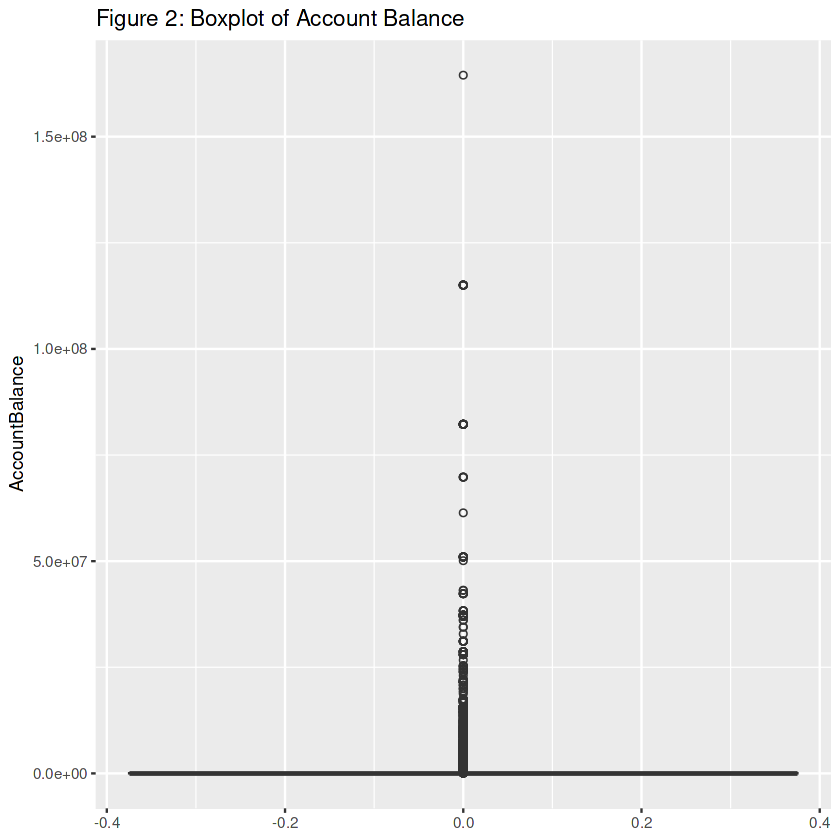

In [58]:
customerDetails %>%
  select(AccountBalance) %>% 
  ggplot(aes(y=AccountBalance)) + geom_boxplot(outlier.shape = 1) + 
  ggtitle("Figure 2: Boxplot of Account Balance")

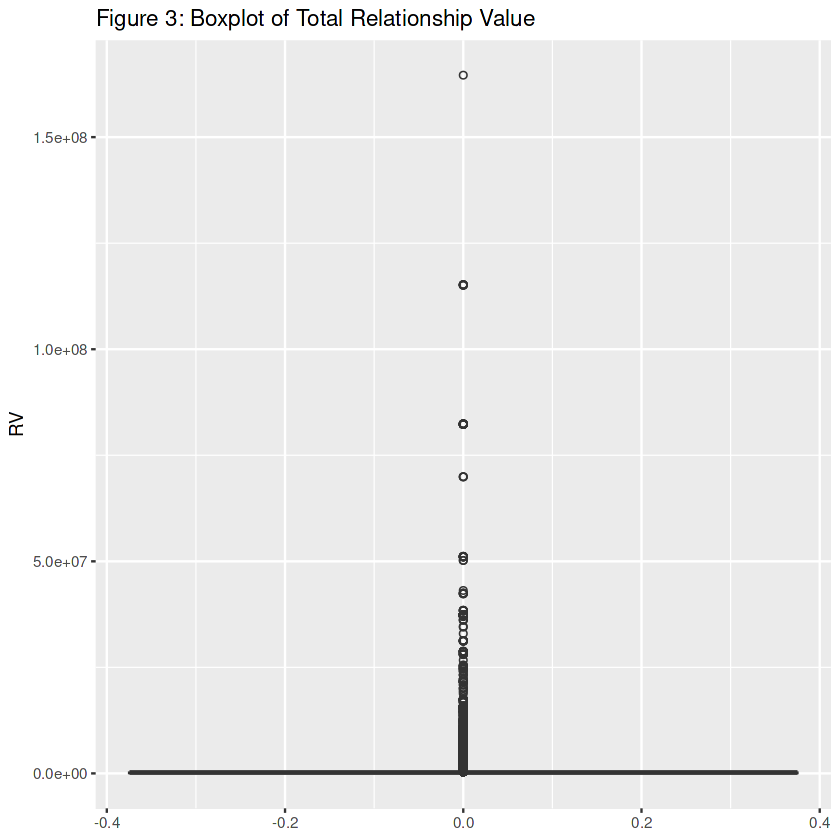

In [59]:
customerDetails %>%
  select(RV) %>% 
  ggplot(aes(y=RV)) + geom_boxplot(outlier.shape = 1) + 
  ggtitle("Figure 3: Boxplot of Total Relationship Value")

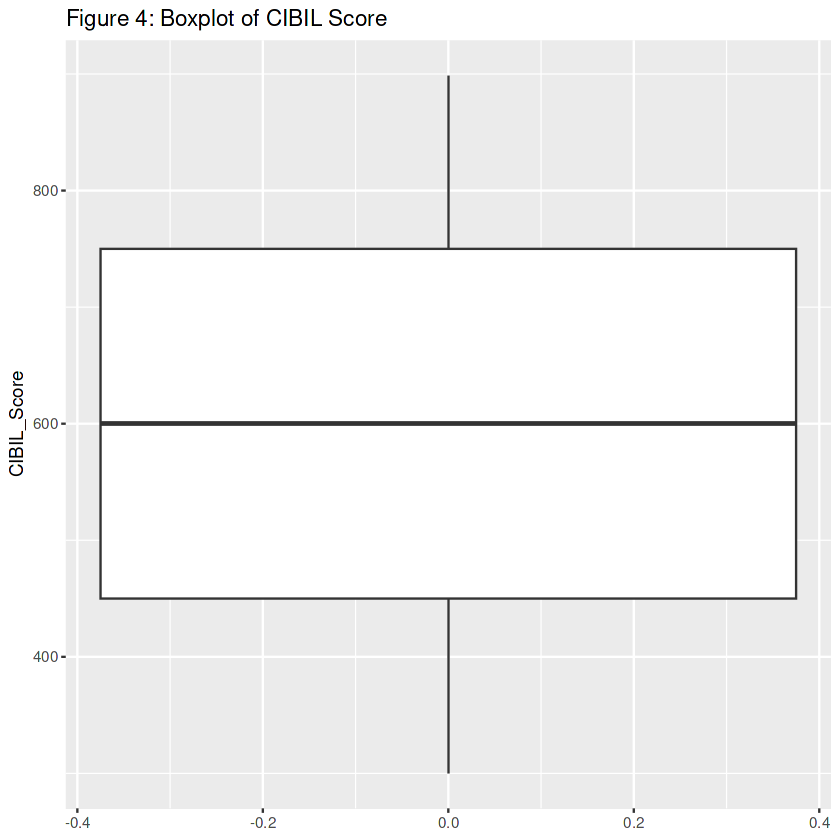

In [60]:
customerDetails %>%
  select(CIBIL_Score) %>% 
  ggplot(aes(y=CIBIL_Score)) + geom_boxplot(outlier.shape = 1) + 
  ggtitle("Figure 4: Boxplot of CIBIL Score")

The Figure 2 and 3 suggests that there is a significant amount of outliers in the distribution of Account Balance and Relationship. Since clustering is based on the euclidean distance of points, these outliers will influence our centriods and cluster assignments. However, instead of removing the outliers we can gain more insights about our customers by keeping them. If a customer is an outlier, is it because of a high account balance or relationship value? Since one of our objectives is to identify high-value customers, this question is important to our task.

#### Data Visualization

Let continue to understand the composition of our dataset by plotting visualizations. The columns HavingCC, HavingFD, HavingLoan have two values 0 or 1. However, since we have integer values, R treats this as a continuous variable. These can cause our pie chart to be confusing. For clarity, let's create new columns that translates these values into Booleans.

In [69]:
boolean_values <- customerDetails %>% 
  select(HavingCC,HavingFD,HavingLoan) %>%
  mutate(CreditCard = case_when(HavingCC==1 ~ TRUE,HavingCC==0 ~ FALSE)) %>% 
  mutate(FixedDeposit = case_when(HavingFD==1 ~ TRUE,HavingFD==0 ~ FALSE)) %>%
  mutate(Loan = case_when(HavingLoan==1 ~ TRUE,HavingLoan==0 ~ FALSE))

head(boolean_values)

Now we can plot our pie graphs

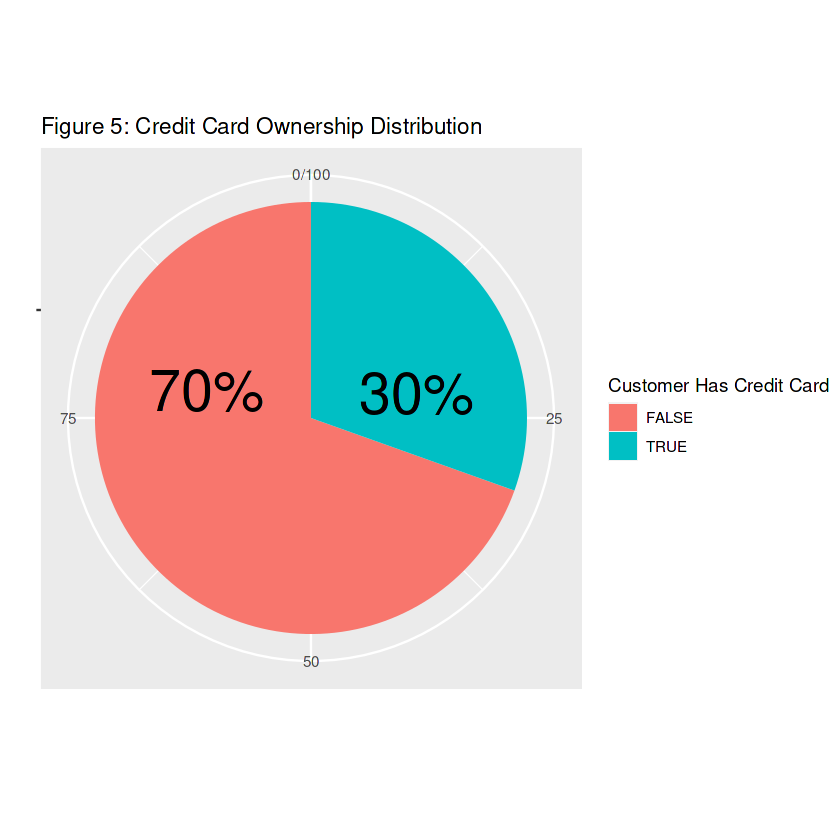

In [79]:
boolean_values %>% 
  group_by(CreditCard) %>% 
  summarise(n=n()) %>% 
  mutate(prop = (n/sum(n))*100) %>%
  ggplot(aes(x="", y=prop, fill=CreditCard)) + geom_bar(width = 1, stat = "identity") +  
  geom_text(aes(x="",y=prop,label = paste0(round(prop,0),"%")),size=12, position = position_stack(vjust = 0.7)) + 
  coord_polar(theta = "y") +
  ggtitle("Figure 5: Credit Card Ownership Distribution") +
  labs(x="",y="",fill="Customer Has Credit Card")
   

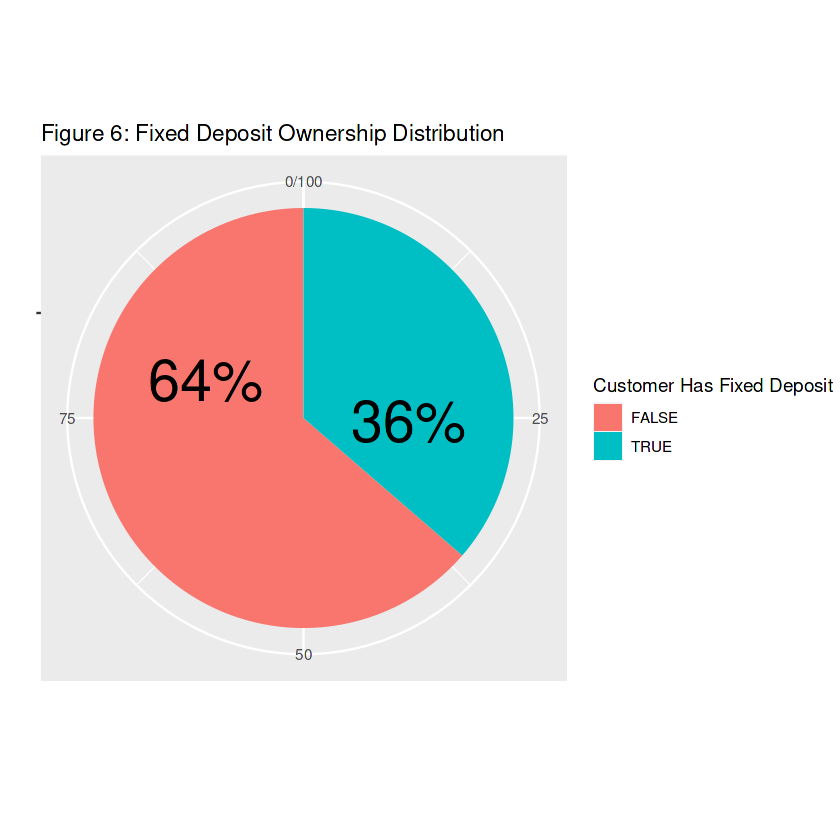

In [81]:
boolean_values %>% 
  group_by(FixedDeposit) %>% 
  summarise(n=n()) %>% 
  mutate(prop = (n/sum(n))*100) %>%
  ggplot(aes(x="", y=prop, fill=FixedDeposit)) + geom_bar(width = 1, stat = "identity") +  
  geom_text(aes(x="",y=prop,label = paste0(round(prop,0),"%")),size=12, position = position_stack(vjust = 0.7)) + 
  coord_polar(theta = "y") +
  ggtitle("Figure 6: Fixed Deposit Ownership Distribution") +
  labs(x="",y="",fill="Customer Has Fixed Deposit")


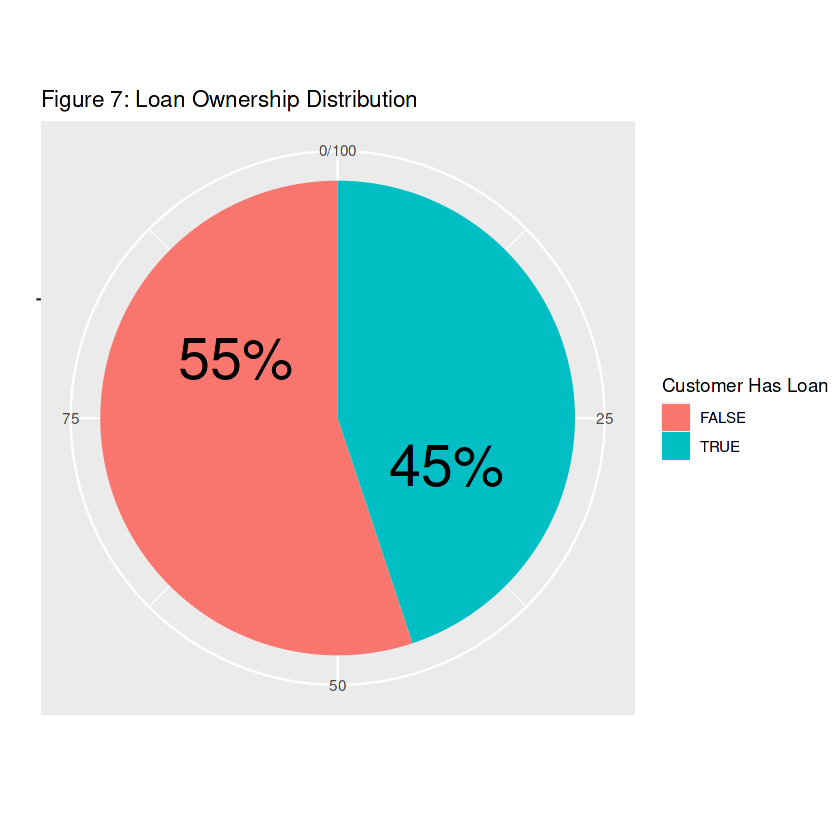

In [82]:
boolean_values %>% 
  group_by(Loan) %>% 
  summarise(n=n()) %>% 
  mutate(prop = (n/sum(n))*100) %>%
  ggplot(aes(x="", y=prop, fill=Loan)) + geom_bar(width = 1, stat = "identity") +  
  geom_text(aes(x="",y=prop,label = paste0(round(prop,0),"%")),size=12, position = position_stack(vjust = 0.7)) + 
  coord_polar(theta = "y") +
  ggtitle("Figure 7: Loan Ownership Distribution") +
  labs(x="",y="",fill="Customer Has Loan")


Summary of Results:

- According to Figure 5, 30% of customers in dataset have a credit card.
- According to Figure 6, 36% of customers in dataset have a fixed deposit.
- According to Figure 7, 45% of customers in dataset have a loan.

#### Correlation Matrix

To compute the correlation matrix, lets select all the quantitative variables from the dataframe.

,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,age,branchCode
AccountBalance,1.000000000,0.0528051077,-0.066984083,0.0014721709,-0.003322374,0.86468000,0.121037090,0.0220693483
HavingFD,0.052805108,1.0000000000,-0.008684947,0.0009302969,0.025989399,0.05992664,0.126257768,0.0461539408
HavingCC,-0.066984083,-0.0086849469,1.000000000,-0.0038661437,0.065776409,-0.05291637,-0.083579195,0.2202744160
CIBIL_Score,0.001472171,0.0009302969,-0.003866144,1.0000000000,0.001423234,0.01181658,0.001091987,0.0002750253
HavingLoan,-0.003322374,0.0259893995,0.065776409,0.0014232336,1.000000000,0.01148394,0.001058586,0.0047606844
RV,0.864680001,0.0599266446,-0.052916368,0.0118165754,0.011483941,1.00000000,0.105447467,0.0230388372
age,0.121037090,0.1262577676,-0.083579195,0.0010919867,0.001058586,0.10544747,1.000000000,0.0808030243
branchCode,0.022069348,0.0461539408,0.220274416,0.0002750253,0.004760684,0.02303884,0.080803024,1.0000000000


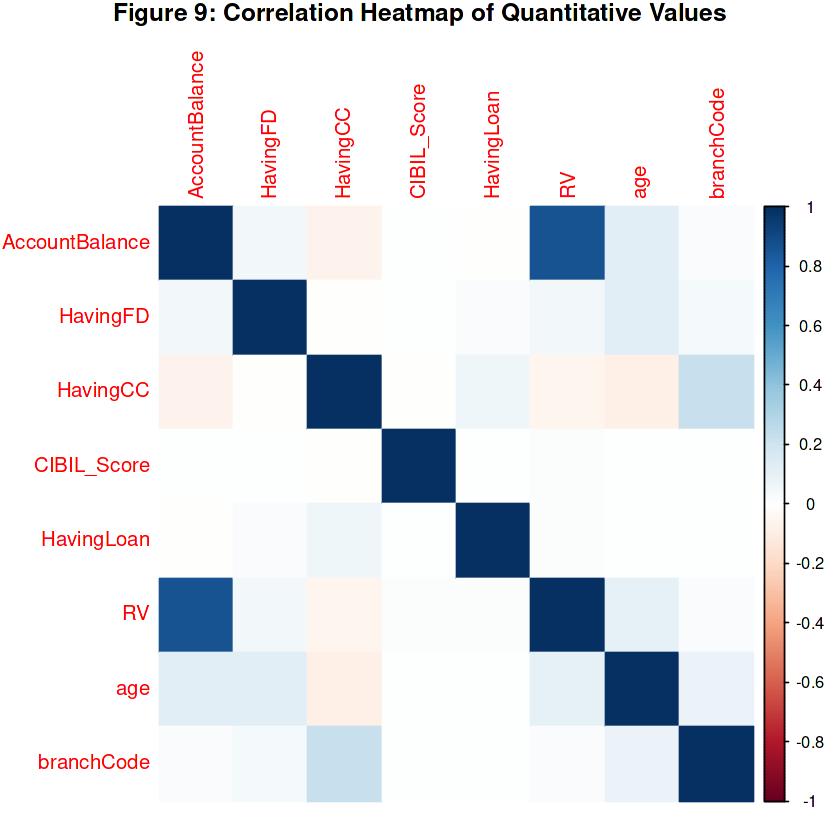

In [88]:
corr_plot<- customerDetails %>% 
  select(AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,age,branchCode) %>% 
  cor()

### print correlation matrix values
corr_plot

library(corrplot)
### View correlation matrix as heatmap
corrplot(corr_plot,method="color",title="Figure 9: Correlation Heatmap of Quantitative Values",mar=c(0,0,1,0)) 

Account Balance and RV yield a correlation coefficient of about 0.865. Since it is close to +1, it suggests a strong positive linear relationship between Account Balance and RV and the below scatterplot supports this. This is to be expected since RV is the It is the sum of all balances of accounts held with the bank (i.e.AccountBalance, FD, Credit Card, Loan). The other correlation coefficients are closer to 0 implying a weak or no linear relationship.

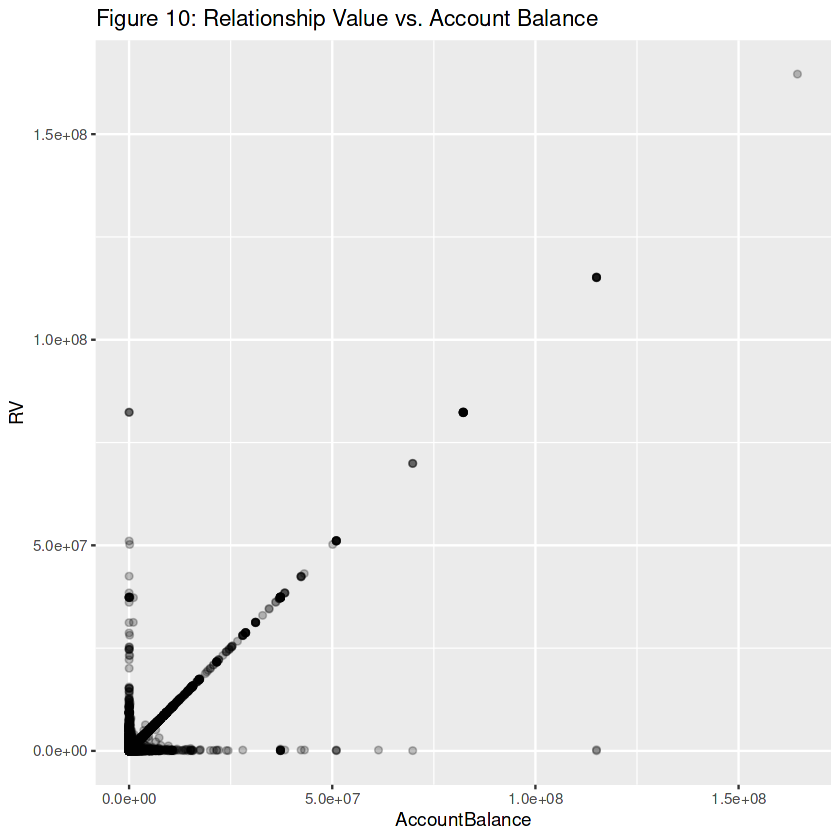

In [91]:
ggplot(customerDetails,aes(AccountBalance,RV)) +
geom_point(alpha = 0.25) +
ggtitle("Figure 10: Relationship Value vs. Account Balance")

The above scatter plot confirms that there is a strong positive linear relationship between Account Balance and RV

<a id="section-four"></a>
## Analyze Phase

<a id="standardize"></a>
#### Standardizing Data

Since clustering involve distance, variable with high range will have a bigger influence on the the clustering. So let's standardize the all the quantitative variables so that all variables are weighed equally.

In [39]:
scaled_df <- customerDetails %>% 
  select(AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,age,branchCode) %>% #Select all numeric variables
  scale() #Scale selected variables and store into scaled_df

# View the first 6 rows of the scaled dataframe
head(scaled_df)

,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,age,branchCode
1,-0.09851159,1.3230740,-0.6616933,0.9536207,-0.9024371,-0.13036924,-0.5796689,-2.070148
2,-0.09851159,-0.7558148,-0.6616933,1.0113177,-0.9024371,-0.18234606,-0.5796689,-2.070148
3,-0.12623424,-0.7558148,-0.6616933,-1.3081006,-0.9024371,-0.14383156,-1.0369457,-2.070148
4,-0.10990026,1.3230740,-0.6616933,1.6113662,-0.9024371,-0.07539043,1.4780765,-2.070148
5,-0.12599479,-0.7558148,-0.6616933,1.3171116,-0.9024371,-0.14480839,-0.8083073,-2.070148
6,-0.12861906,-0.7558148,-0.6616933,-0.5003430,-0.9024371,-0.06345395,-0.6939881,-2.070148


<a id="elbow-plot"></a>
#### Choosing Optimal k (Elbow Method)

In order to the determine the optimal number of clusters (k), we can plot discrete values of k against total variation within clusters. The variation within each cluster can be measured using Within-Cluster Sum of Squares (WCSS). This is just the sum of squared errors (SSEs) of all data points in a cluster. 

\begin{equation}
SSE = \sum\limits_{i=1}^{k} \sum\limits_{x_{j} \in C_i} ||x_{j} - \mu_{i}||^2 
\end{equation}

where $\mu_{i}$ is centroid of the $i$-th cluster. The centroid is the mean of the data points in each cluster. i.e. $\mu_{i} = \frac{1}{j_{i}} \sum\limits_{x \in C_i} X$ 


As the number of clusters (k) increase, the total variation within each cluster (i.e. SSE) will decrease. However after a certain K value, we should notice that the variation does not decrease as quickly.

The location of the bend (or elbow) in the plot is considered to be the optimal amount of clusters because after that point there is little to no variation.


In [40]:
#our k values are integers starting at 1 and ending at 10
k <- 1:10
wcss <- numeric(10)

# use set.seed() to ensure that our results can be reproduced
set.seed(123)

for (i in k) {
  #The kmeans() function performs k-means clustering and one of its output values is tot.withinss
  km.out <- kmeans(scaled_df,centers = i,nstart=25)
  #nstart is the number of initial configurations. 
  #i.e. nstart=10 means that 10 random iniations will be attempted and the one with the lowest total WCSS will be chosen.
  wcss[i] <- km.out$tot.withinss
  #tot.withinss is the total WCSS for each k
}

library(tibble)
#save as a dataframe so that we can plot
wcss_df <- tibble(clusters=k,wcss=wcss)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 47449750)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 47449750)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 47449750)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 47449750)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 47449750)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 47449750)”


#### Elbow Plot

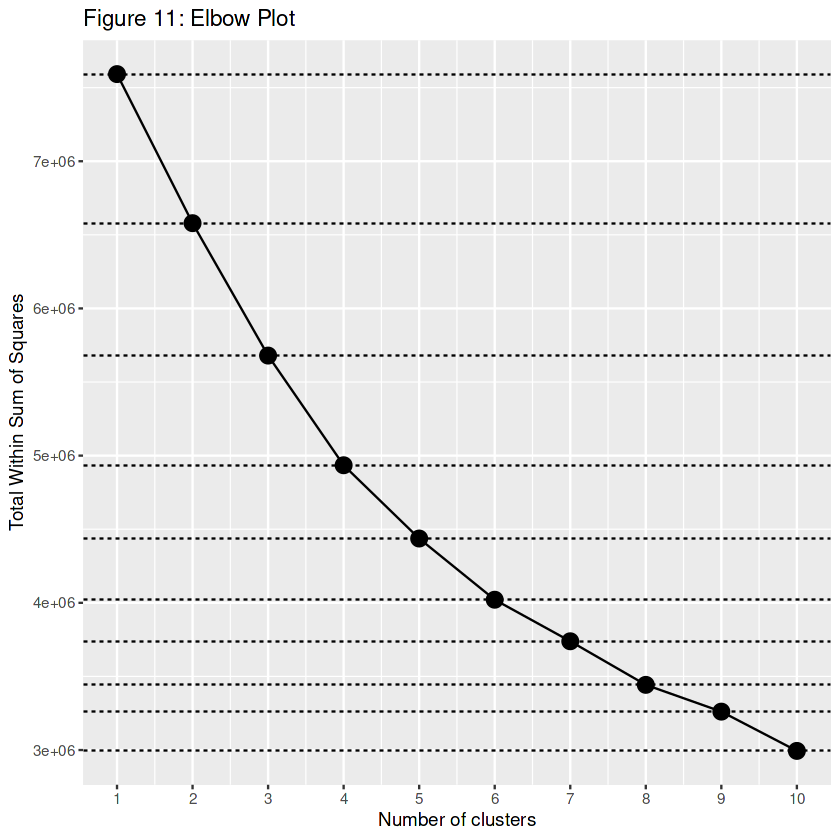

In [92]:
ggplot(wcss_df, aes(x=clusters,y=wcss)) +
  geom_point(size = 4)+
  geom_line() +
  scale_x_continuous(breaks = 1:10) +
  xlab('Number of clusters') +
  ylab('Total Within Sum of Squares') +
  geom_hline(yintercept = wcss,linetype = 'dashed') +
  ggtitle("Figure 11: Elbow Plot")

The dashed lines make it clear that after k=5 the reduction in WCSS (variation) is much slower. Therefore the optimal number of clusters in 5.

<a id="k-means"></a>

#### K-means clustering

K-means clusters groups similar data into clusters using euclidean distance. i.e. it uses the principle that similar points have smaller euclidean distance. Since we've determined that optimal number of clusters (i.e. k=5), we can now perform k-means cluster using the kmeans() function in R. This function will perform the following steps:

1. Randomly Pick k Centroids/Centers
2. Assign each data point to the centroid its closest to (determined by euclidean distance) forming cluster
3. Compute new centroid of each cluster (by calculating the mean of each cluster)
4. Repeat steps 2 and 3 several times (choosing a new centroid and assignment data points) until cluster memberships no longer change (i.e. the Sum of Squared Errors (SSE) between the data points and centroid is minimized).

Note the final cluster groupings depend on inital random selection of k centroids. A completely different random selection of k centroids can produce different clusters with a smaller SSE. Therefore we will use the nstart=25 option so that the kmeans function will attempt 25 initial configuration and select the best one (with smallest SSE)

In [42]:
#use set.seed() function to ensure that our results are reproducible
set.seed(123)

# Set the number of clusters to 5
k <- 5
kmeans_result <- kmeans(scaled_df,centers = k,nstart = 25)

Let's add our clusters id numbers to our customerDetails so that we can visualize the results.

In [43]:
customerDetails$cluster_id <- kmeans_result$cluster

<a id="cluster-analysis"></a>

#### Cluster Analysis

Let's try to understand the characteristics of each cluster. The centroid/center is considered to be the defining characteristic of k-means clusters. Since this process uses the mean to calculate each centroid, we will calculate the mean of all data points within each cluster.

In [44]:
cluster_groups <- customerDetails %>%
  select(AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,age,branchCode,cluster_id) %>% 
  aggregate(by=list(customerDetails$cluster_id),FUN=mean)

cluster_groups[-1]

AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,age,branchCode,cluster_id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
456067.67,0.5746983,0.04729006,601.1989,0.4353301,521735.8,56.66341,1.6986430,1
53714.61,0.3086645,0.01629790,599.7389,0.4361919,147375.1,35.16859,0.3499584,2
22649.51,0.3529014,1.00000000,598.5585,0.4994446,135585.2,36.63828,1.8125917,3
47106675.36,0.7697368,0.00000000,600.4474,0.2368421,46107293.2,64.77632,1.7565789,4
90047.03,0.3472434,0.00000000,600.2177,0.4203887,180032.6,35.86636,2.0000000,5


Context: Some banks in India have a minimum monthly account balance requirement based on the customer's residence type. The requirements vary based on the bank, generally its:
- Rs 10 000 for urban/metro areas
- Rs 5000-1000 for semi-urban
- Rs 2000-500 for urban

From the cluster_groups table we can identify some characteristics of the mean point in each cluster:

- Cluster 1
    - Average CIBIL Score (500-649 range)
    - Mean Age is between 50s and 60s
    - Account Balance in Rs 400000 range
- Cluster 2
    - Average CIBIL Score (500-649 range)
    - Mean Age is between 30s and 40s
    - Account Balance in Rs 50000 range
- Cluster 3
    - Lowest Account Balance in Rs 20000 range
    - Average CIBIL Score (500-649 range)
    - Lowest Relationship Value
    - Has Credit Card
    - Mean Age is between 30s and 40s
- Cluster 4
    - Highest Account Balance in 40000000 range
    - Highest Relationship Value
    - Does not have Credit Card
    - Average CIBIL Score (500-649 range)
    - Mean Age is between 60s and 70s
- Cluster 5
    - Account Balance in Rs 90000 range
    - Mean Age is between 30s and 40s
    - Average CIBIL Score (500-649 range)
    - Does not have Credit Card

We can plot visualizations to verify that these characteristics are consistent with the remaining data points within each cluster.

First let's view how many data points (i.e. customers are in each cluster) and the WCSS of each cluster. This helps evaluates the clustering since good models have a low SSE within each cluster and overall.

[1]  982481.0  840636.5 1059133.0  331701.3 1225610.8

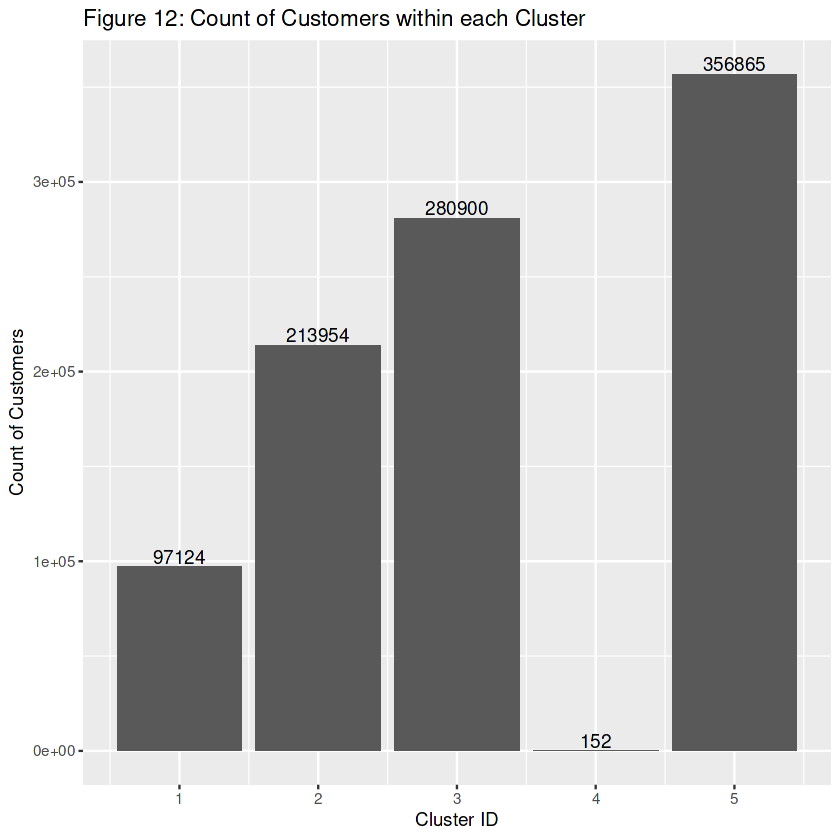

In [93]:
customerDetails %>% 
  group_by(cluster_id) %>% 
  summarise(count=n()) %>% 
  ggplot() + geom_bar(aes(x=cluster_id,y=count),stat = "identity") +
  geom_text(aes(x=cluster_id,y=count,label = count), vjust = -0.2) +
  ggtitle("Figure 12: Count of Customers within each Cluster") +
  labs(x="Cluster ID",y="Count of Customers")


kmeans_result$withinss

This tells us that cluster 4 have the lowest number of data points and WCSS. Even though the WCSS is low this could be due to the small number of data points. Therefore we need to investigate this further. Cluster 5 has the highest number of data points and WCSS.

#### Geographic Characteristics of Clusters

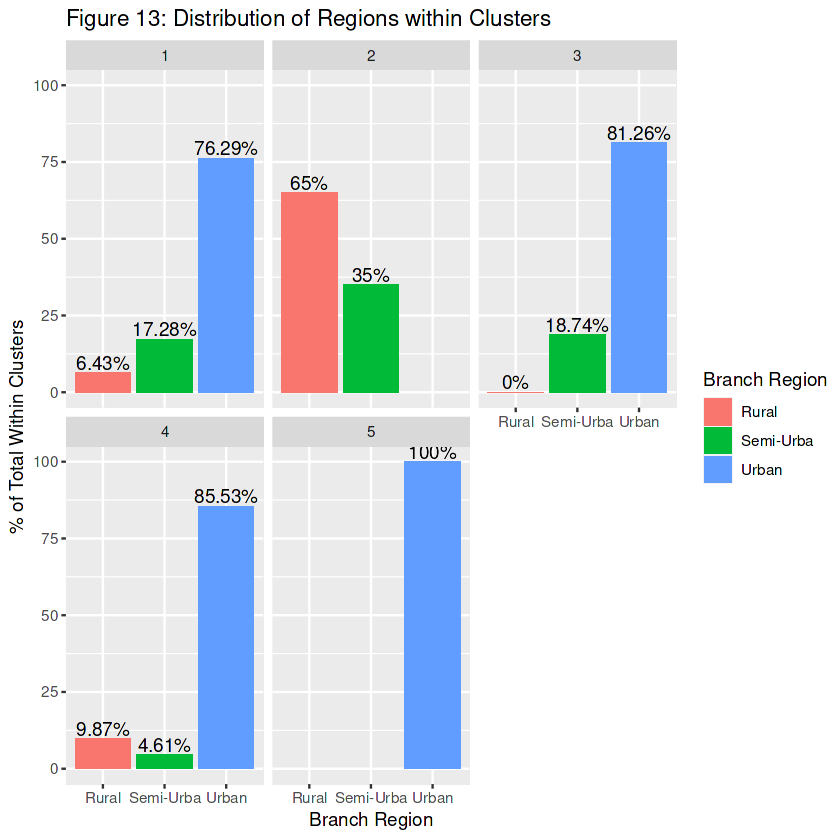

In [99]:
customerDetails %>%
  count(BranchType,cluster_id) %>% 
  group_by(cluster_id) %>% 
  mutate(pct=round((n/sum(n))*100,2)) %>% 
  ggplot(aes(x=BranchType,y=pct,fill=BranchType)) + geom_bar(position="dodge",stat = "identity") + 
  facet_wrap(~cluster_id) + 
  geom_text(aes(x=BranchType,y=pct,label = paste0(pct,"%")), vjust = -0.2) +
  labs(y="% of Total Within Clusters",x="Branch Region",fill="Branch Region") +
  ggtitle("Figure 13: Distribution of Regions within Clusters")


This shows us that 65% of cluster 2 customers are from rural areas and the rest are from semi-urban areas. Cluster 2 has no customers from Urban Areas. While the other clusters have little to no customers from rural areas. All customers from cluster 5 are from Urban areas.

#### CIBIL Scores within each Clusters

We observed that the mean CIBIL Score varied significantly between clusters. Let's plot a boxplot for each of the clusters to see the CIBIL_Score for all data points in each cluster.

cluster_id,Q1,median,Q3,IQR
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,451.00,601,752.00,301.0
2,450.00,600,751.00,301.0
3,449.00,598,748.00,299.0
4,466.75,589,748.25,281.5
5,450.00,601,751.00,301.0


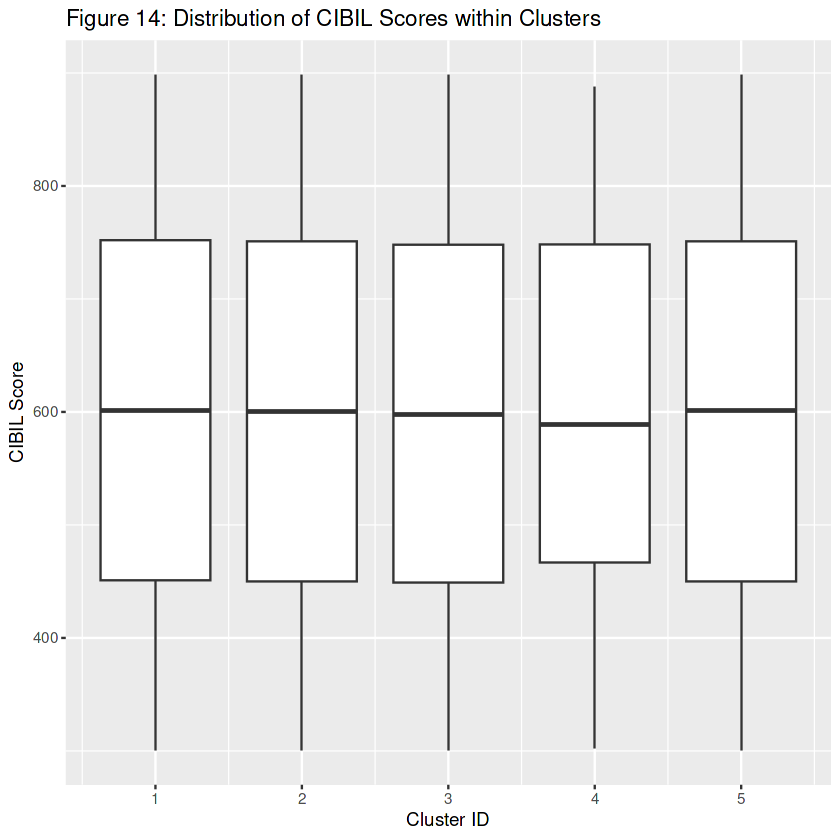

In [101]:
customerDetails %>%
  select(CIBIL_Score,cluster_id) %>% 
  group_by(cluster_id) %>%
  ggplot(aes(x=cluster_id,y=CIBIL_Score,group=cluster_id)) +geom_boxplot(outlier.shape = 1) +
  ggtitle("Figure 14: Distribution of CIBIL Scores within Clusters") +
  labs(y="CIBIL Score", x="Cluster ID")
  

customerDetails %>%
  select(CIBIL_Score,cluster_id) %>% 
  group_by(cluster_id) %>% 
  summarize(Q1=quantile(CIBIL_Score,probs = 0.25),median=median(CIBIL_Score),Q3=quantile(CIBIL_Score,probs = 0.75)) %>% 
  mutate(IQR=Q3-Q1)


Figure 14 implies that the IQR of the CIBIL score of each cluster is fairly consistent with each other. Each of the box are consistent in length and the median is in the middle. This suggests that the spread of CIBIL is symmetric  

#### Account Balance within each Clusters

cluster_id,Q1,median,Q3,IQR
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,17434,83231,326314,308880
2,2912,10306,34373,31461
3,4565,14469,32755,28190
4,31128912,37254856,50999668,19870756
5,4690,18080,84285,79595


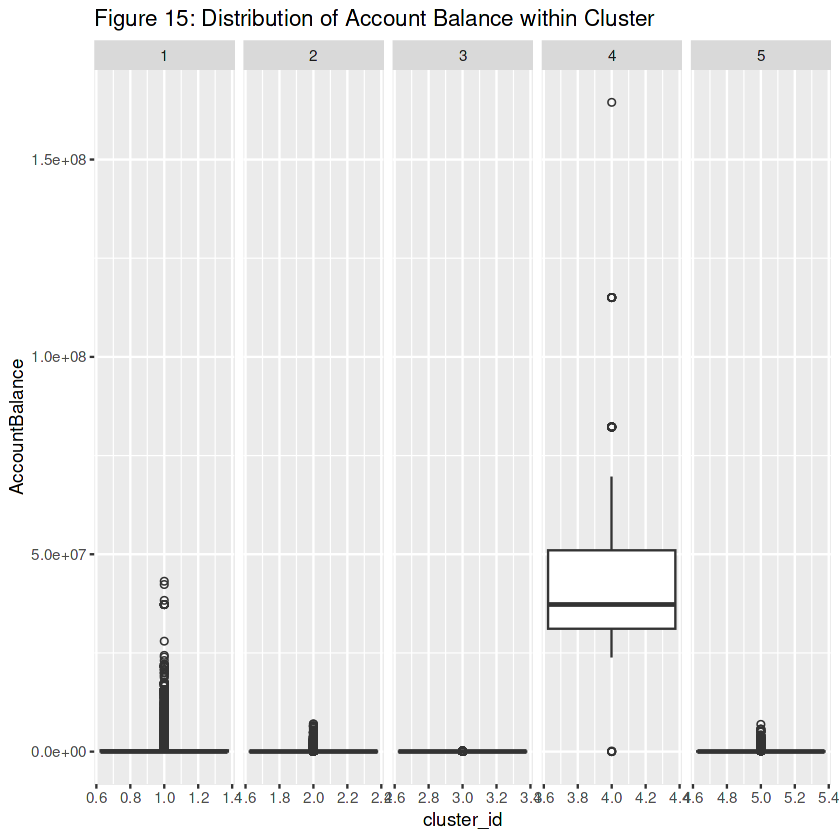

In [102]:
customerDetails %>%
  select(AccountBalance,cluster_id) %>% 
  ggplot(aes(x=cluster_id,y=AccountBalance,group=cluster_id)) +
  geom_boxplot(outlier.shape = 1) + facet_grid(~cluster_id,scales = "free") +
  ggtitle("Figure 15: Distribution of Account Balance within Cluster")

customerDetails %>%
  select(AccountBalance,cluster_id) %>% 
  group_by(cluster_id) %>% 
  summarize(Q1=quantile(AccountBalance,probs = 0.25),median=median(AccountBalance),Q3=quantile(AccountBalance,probs = 0.75)) %>% 
  mutate(IQR=Q3-Q1)

Cluster 4 as a whole has a significantly higher account balance than the other clusters. The box bigger, suggesting there is more spread within the IQR. Cluster 3 has the smallest IQR, implying that the data points are more compact.

#### Having Fixed Deposit within each Clusters

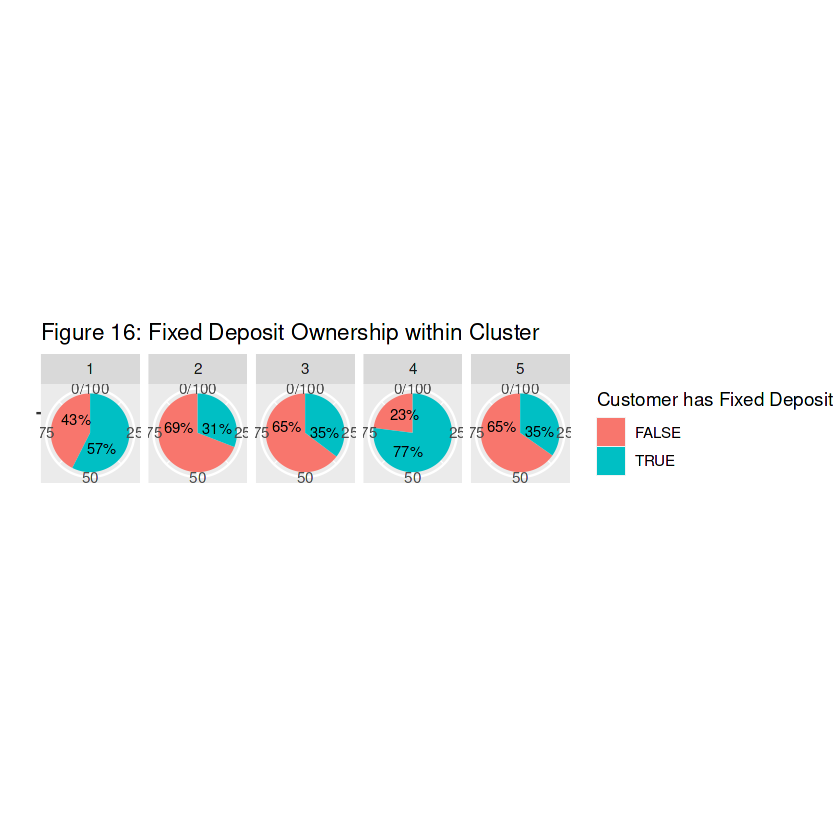

In [106]:
customerDetails %>%
  mutate(FixedDeposit = case_when(HavingFD==1 ~ TRUE,HavingFD==0 ~ FALSE)) %>%
  count(FixedDeposit,cluster_id) %>%
  group_by(cluster_id) %>% 
  mutate(prop = (n/sum(n))*100) %>%
  ggplot(aes(x="", y=prop, fill=FixedDeposit)) + geom_bar(width = 1, stat = "identity") + 
  facet_grid(~cluster_id) + geom_text(aes(x="",y=prop,label = paste0(round(prop,0),"%")),size=3, position = position_stack(vjust = 0.7)) + 
  coord_polar(theta = "y") +
  labs(x="",y="",fill="Customer has Fixed Deposit") +
  ggtitle("Figure 16: Fixed Deposit Ownership within Cluster")

- In cluster 4, 77% of customers have a fixed deposit. 
- In cluster 4, 57% of customers have a fixed deposit
- In cluster 2,3,5, only about 30-35% of customers have a fixed deposit in each cluster.

#### Having Credit Card within each Clusters

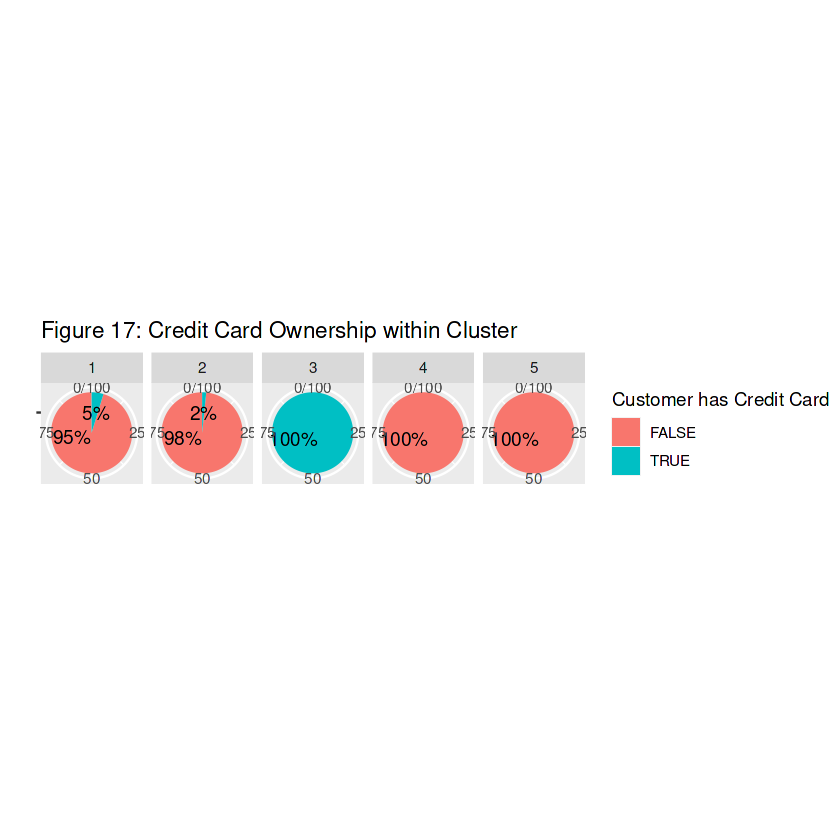

In [107]:
customerDetails %>%
  mutate(CreditCard = case_when(HavingCC==1 ~ TRUE,HavingCC==0 ~ FALSE)) %>%
  count(CreditCard,cluster_id) %>%
  group_by(cluster_id) %>% 
  mutate(prop = (n/sum(n))*100) %>%
  ggplot(aes(x="", y=prop, fill=CreditCard)) + geom_bar(width = 1, stat = "identity") + 
  facet_grid(~cluster_id) + geom_text(aes(x="",y=prop,label = paste0(round(prop,0),"%")), position = position_stack(vjust = 0.7)) + 
  coord_polar(theta = "y") +
  labs(x="",y="",fill="Customer has Credit Card") +
  ggtitle("Figure 17: Credit Card Ownership within Cluster")

- In cluster 1,2, only 5% to 2% of customers have a credit card.
- In cluster 4 and 5, 0% of customers have a credit card.
- In cluster 3, 100% of customers have a credit card.

#### Having Loan within each Clusters

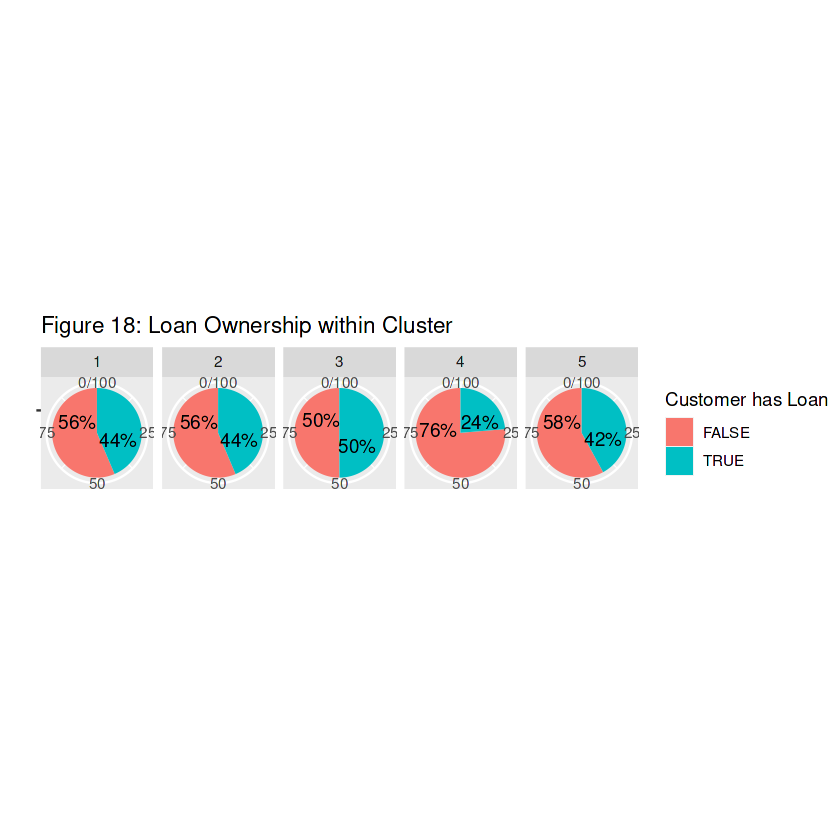

In [113]:
customerDetails %>%
  mutate(Loan = case_when(HavingLoan==1 ~ TRUE,HavingLoan==0 ~ FALSE)) %>%
  count(Loan,cluster_id) %>%
  group_by(cluster_id) %>% 
  mutate(prop = (n/sum(n))*100) %>%
  ggplot(aes(x="", y=prop, fill=Loan)) + geom_bar(width = 1, stat = "identity") + 
  facet_grid(~cluster_id) + geom_text(aes(x="",y=prop,label = paste0(round(prop,0),"%")), position = position_stack(vjust = 0.7))+ 
  coord_polar(theta = "y") + 
  labs(x="",y="",fill="Customer has Loan") + 
  ggtitle("Figure 18: Loan Ownership within Cluster")
                                      

- In cluster 4, only 24% of customers have a loan.
- In cluster 1,2 and 5, only 42% to 44% of customers have a loan.
- In cluster 3, 50% of customers have a loan.

##### Age Group Distribution within each clusters

We determined the following mean ages for each cluster:

In [53]:
customerDetails %>%
  select(age,cluster_id) %>% 
  aggregate(by=list(customerDetails$cluster_id),FUN=mean)

Group.1,age,cluster_id
<int>,<dbl>,<dbl>
1,56.66341,1
2,35.16859,2
3,36.63828,3
4,64.77632,4
5,35.86636,5


Let's see if these mean ages are representative of the rest of the data points in the cluster.

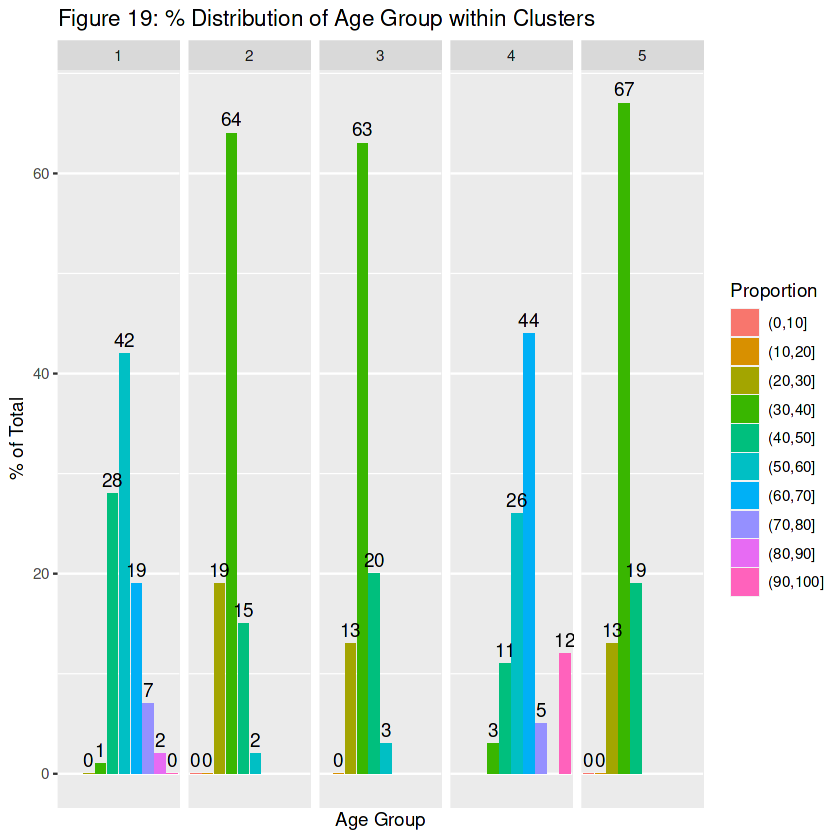

In [115]:
total_rows <- customerDetails %>%
  group_by(cluster_id) %>%
  nrow()

customerDetails %>%
  mutate(age_grp = cut(age, seq(0,100,by=10))) %>% 
  count(cluster_id,age_grp) %>%
  group_by(cluster_id) %>% 
  mutate(pct=round((n/sum(n))*100),0) %>% 
  ggplot(aes(x=age_grp,y=pct))+
  geom_bar(aes(fill = age_grp),stat="identity") + 
  facet_grid(~cluster_id,space = "free") + 
  geom_text(aes(x=age_grp,label=pct, y = pct), stat = "identity", vjust = -0.5) + 
  labs(y = "% of Total", x="Age Group", fill="Proportion") + scale_x_discrete(breaks=NULL) +
  ggtitle("Figure 19: % Distribution of Age Group within Clusters")

- In cluster 2,3 and 5, the dominant age group is 30s-40,
- In cluster 1 and 4, the top 2 age groups are 50s-60s and 60s-70s. 
    - Cluster 1 has more customers in the 50s-60s while cluster 4 has more customers in the 60s and 70s.

Cluster 1 and 4 stand out since they consists of customers nearing retirement or already retired. Let's plot a boxplot of the ages in each cluster to see of we can gather more insight.

cluster_id,Q1,median,Q3,IQR
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,55,62,12
2,31,34,38,7
3,32,35,40,8
4,52,68,70,18
5,32,35,39,7


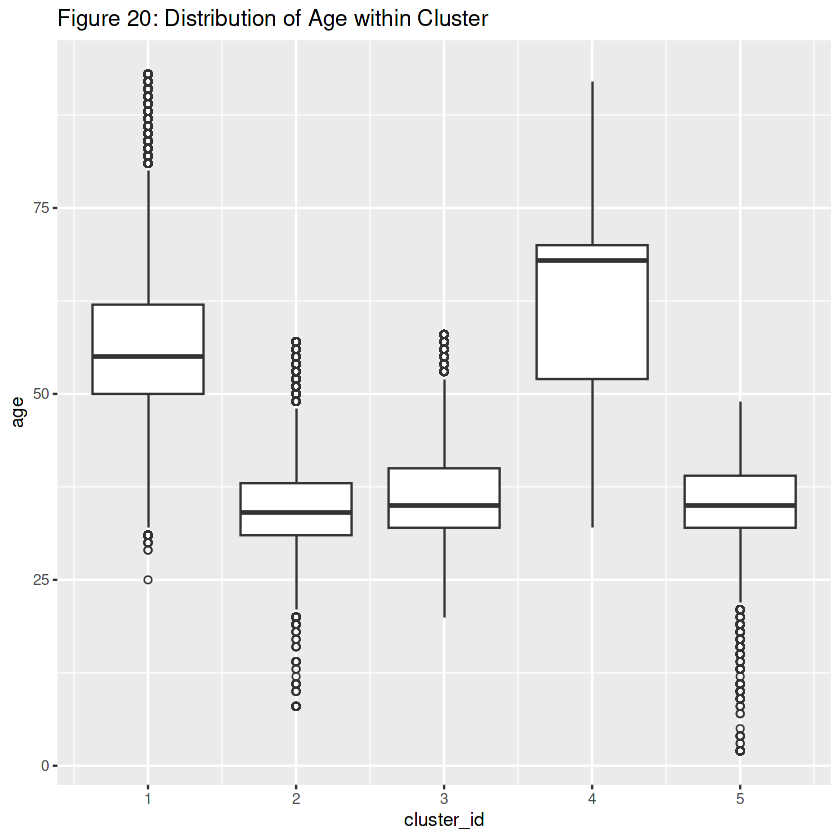

In [116]:
customerDetails %>%
  select(age,cluster_id) %>% 
  group_by(cluster_id) %>%
  ggplot(aes(x=cluster_id,y=age,group=cluster_id)) +geom_boxplot(outlier.shape = 1) +
  ggtitle("Figure 20: Distribution of Age within Cluster")

customerDetails %>%
  select(age,cluster_id) %>% 
  group_by(cluster_id) %>% 
  summarize(Q1=quantile(age,probs = 0.25),median=median(age),Q3=quantile(age,probs = 0.75)) %>%
  mutate(IQR=Q3-Q1)

The box lengths of cluster 2,3, and 5 are fairly consistent and narrow compared cluster 1 and cluster 4. This implies that there is spread of customers ages in clusters 2,3 and 5. 

**Cluster 1 and 4 Comparison**
- Cluster 4's box is longer than longer than cluster 1, this means the customers ages in cluster 4 are disperse.
- The median for cluster 4 is closer to Q3, which means more values are concentrated on the right side of the tail. 25% of customer ages are between 68 and 70 alone. (i.e. there are higher number of customers in their lates 60 and early 70s compared to 50s.)
- The median for cluster 1 is closer to Q1, which means more customers ages are concentrated between 50 and 55.


<a id="cluster-insights"></a>
#### **Cluster Insights**

- Cluster 1
    - 76% of customers are from Urban Areas
    - 50% of CIBIL Scores between 450 and 750
    - 57% of customers have a Fixed Deposit
    - 5% of customers have a Credit Card
    - 44% of customers have a loan
    - Majority of customers between 50s and 60s
    - Around 50% of customers Account Balances lie Rs 17,000-320000 range
- Cluster 2
    - 65% of customers are from Rural Areas
    - 35% of customers are from Semi-Urban Areas
    - 50% of CIBIL Scores between 450 and 750
    - 44% of customers have a loan
    - 31% of customers have a Fixed Deposit
    - 2% of customers have a Credit Card
    - Majority of customers between 30s and 40s
    - Does not have Loan
    - Around 50% of customers Account Balances lie Rs 2000-34000 range
- Cluster 3
    - 81% of customers are from Urban areas 
    - 50% of CIBIL Scores between 450 and 750
    - 50% of customers have a loan
    - 35% of customers have a Fixed Deposit
    - 100% of customers have a Credit Card
    - Around 50% of customers Account Balances lie Rs 4000-32000 range
    - Majority of customers between 30s and 40s
- Cluster 4
    - 85% of customers are from Urban Areas
    - Highest Account Balance (75% of customers have account balance above 30000000 range)
    - Highest Relationship Value
    - 77% of customers have a Fixed Deposit
    - 0% of customers have a Credit Card
    - 50% of CIBIL Scores between 450 and 750
    - 24% of customers have a loan
    - High concentration of customers in lates 60s and early 70s (50% of customers between 50s-70s)
- Cluster 5
    - 100% of customers are from Urban Areas
    - Around 50% of customers Account Balances lie Rs 4000-84000 range
    - 50% of CIBIL Scores between 450 and 750
    - 42% of customers have a loan
    - 35% of customers have a Fixed Deposit
    - 0% of customers have a Credit Card
    - Majority of customers between 30s and 40s

<a id="high-value"></a>
#### **Identify High-Value Customers**

Based on the insights gain, it is evident that cluster 4 stands out as having customers with highest account balance and relationship values. It also has the highest proportion of customers with a fixed deposit. Over 75% of customers of in cluster 4 are 50 or older. Therefore since they have a strong relationship with the bank, we want to keep them with the bank by providing priority service. 

<a id="recommendations"></a>
### Personalized Marketing Recommendations

#### Cluster 1 (Urban Customers with Good CIBIL Scores, Fixed Deposits, Loans, and Low Credit Card Usage (50s and 60s))

- Since 44% of customers have loans, offer debt consolidation or loan restructing options
    - ex. Offer options to convert customers' debt into one loan payment with lower or same interest rates.
- Since 57% of customers have fixed deposits, promote fixed deposits renewals by offering competitive interest rates.
- Recognize that a significant portion of these customers are retired or nearing retirement. Therefore highlight retirement planning services and long-term investments options.
- Since only 5% of customers have credit cards, offer credits suited for seniors
    - i.e. Medical coverage, travel insureance
- highlight banking solutions specifically for urban customers.
    - ex. advertise the bank's self-service portal like direct deposit, pre-authorized payments for credit cards.
    
#### Cluster 2 (Rural and Semi-Urban Customers with Loans, Limited Fixed Deposits, and Low Credit Card Usage (30s and 40s))

- Offer certain incentives for those who maintain a certain account balance or monthly deposit
    - ex. waived fees, cash rewards
- According to a Kantar ICUBE 2022 study, 36% of digital payments users are from Rural India. The top activities that Rural customers use internet for are Entertainment, Communication and Social media. Therefore by promoting digital literacy programs this can encourage rural customers to complete their banking tasks online.
    - ex. target rural customers that need to travel long distances to reach branches
- Since 44% of customers in this cluster have loans, offer debt management and credit building tips.

#### Cluster 3 (Urban Customers with Loans, Credit Cards, and Moderate Fixed Deposits (30s and 40s))

- Highlight banking solutions specifically for urban customers.
    - ex. advertise the bank's self-service portal like direct deposit, pre-authorized payments for credit cards.
- Since 100% of customers have a credit card, offer credit cards rewards and limits that align with their spending habits and target ages 30s-40s
    - i.e. this would require more analysis on customers' credit card spending patterns
- Promote Fixed Deposits by offering competitive interest rates.
- Offer financial planning and investment options for customers in their 30s and 40s.
    - ex. savings accounts for retirements, health/life insurance, weddings
    - ex. offer RESP/education fund for kids

#### Cluster 4 (Urban Customers, High Account Balances, *High-Value Customers*)
- Since these customers have high account balances, offer priority service and personalized investment services.
- Since these customers have a high relationship value with the bank, we want to keep them with the bank.To improve customer retention, develop loyalty/benefits programs to reward long-term customers in this cluster.
- Recognize that a significant portion of these customers are retired or nearing retirement. Therefore highlight retirement planning services and long-term investments options.
- Offer educational workshops or content focused on retirement planning and investment options.
- send campaigns to those with a fixed deposits encouraging them to renew their FD. 
- Since 0% of customers have a credit card, Create a credit card with features tailored to seniors. (i.e. travel benefits/insurance, boost retirement or child's education savings,no annual fee,Earning cash back)

#### Cluster 5 (Urban Customers, Average CIBIL Scores, 100% of customers have a loan)
- Since 42% of customers have loans, promote debt consolidation and refinancing options.
    + ex. since this consists 100% urban customers in their 30s and 40s, they have loans from owning a home, car, etc. Offer options to convert customers' debt into one loan payment with lower or same interest rates.
- Since customers have no credit cards, offer educational content on credit building cards
- Given that all customers in this cluster are from urban areas, highlight banking solutions specifically for urban customers.
    - ex. advertise the bank's self-service portal like direct deposit, pre-authorized payments for credit cards.

#### References

Benson, D., Grundl, S., & Windle, R. (2020). How do Rural and Urban Retail Banking Customers Differ? FEDS Notes. Washington: Board of Governors of the Federal Reserve System. https://doi.org/10.17016/2380-7172.2513

DBS digibank. (2021, October 27). High Yield Savings Accounts. DBS; DBS digibank. https://www.dbs.com/digibank/in/articles/save/high-yield-savings-accounts#

Farrell, S. (2020, September 22). Urban Vs. Rural Banking. Quality Data Systems Blog. https://blog.qualitydatasystems.com/urban-vs.-rural-banking

IAMAI , & KANTAR. (2023). Internet in India 2022. In iamai.in (pp. 12–39). Internet and Mobile Association of India. https://www.iamai.in/sites/default/files/research/Internet%20in%20India%202022_Print%20version.pdf

Nigam, A. (2020, August 5). The rural-urban divide: Why cash is still the king in India’s rural regions. The Times of India. https://timesofindia.indiatimes.com/blogs/voices/the-rural-urban-divide-why-cash-is-still-the-king-in-indias-rural-regions/

Starmer, J. (2018, May 23). StatQuest: K-means clustering. YouTube; StatQuest with Josh Starmer. https://youtu.be/4b5d3muPQmA?si=GOfoyHzSSMf9DPdN

Vijay Kotu, & Balachandre Deshpande. (2019). Data science : concepts and practice. Morgan Kaufmann Publishers.